In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
transforms =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [3]:
train_dataset = datasets.ImageFolder(root=r"C:\Users\sreep\Downloads\Places2_simp\Places2_simp", transform=transforms)

In [4]:
test_dataset = datasets.ImageFolder(root=r"C:\Users\sreep\Downloads\testset\testset\testset", transform=transforms)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor(2)


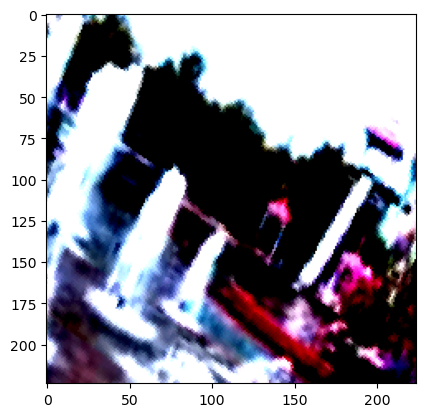

In [7]:
# import plot library
import matplotlib.pyplot as plt
# iterate the dataloader
images, labels = next(iter(train_dataloader))

# show the data
plt.imshow(images[1].permute(1, 2, 0))
print("Label: " + str(labels[1]))

In [9]:
model = models.resnet34(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# map to device
model = model.to(device)
#model = model.cuda() if device else model
# Freeze the weights of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Define the new layers
num_ftrs = model.fc.in_features
new_layers = nn.Sequential(
    nn.Linear(num_ftrs, 255),
    nn.ReLU(),
    #nn.Dropout(0.4),
    nn.Linear(255, 40)
)
#model.fc = model.fc.cuda() if use_cuda else model.fc

# Concatenate the pre-trained layers with the new layers
model.fc = new_layers
# Set the requires_grad attribute of the new layers to True
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    #model.train()
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t.to(device))
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
    model.train()

Epoch 1

Epoch [1/5], Step [0/1250], Loss: 3.7525
Epoch [1/5], Step [20/1250], Loss: 3.7321
Epoch [1/5], Step [40/1250], Loss: 3.7225
Epoch [1/5], Step [60/1250], Loss: 3.7519
Epoch [1/5], Step [80/1250], Loss: 3.6182
Epoch [1/5], Step [100/1250], Loss: 3.6486
Epoch [1/5], Step [120/1250], Loss: 3.6667
Epoch [1/5], Step [140/1250], Loss: 3.6257
Epoch [1/5], Step [160/1250], Loss: 3.7196
Epoch [1/5], Step [180/1250], Loss: 3.6879
Epoch [1/5], Step [200/1250], Loss: 3.6296
Epoch [1/5], Step [220/1250], Loss: 3.7057
Epoch [1/5], Step [240/1250], Loss: 3.7265
Epoch [1/5], Step [260/1250], Loss: 3.7031
Epoch [1/5], Step [280/1250], Loss: 3.6811
Epoch [1/5], Step [300/1250], Loss: 3.7342
Epoch [1/5], Step [320/1250], Loss: 3.6765
Epoch [1/5], Step [340/1250], Loss: 3.7140
Epoch [1/5], Step [360/1250], Loss: 3.6986
Epoch [1/5], Step [380/1250], Loss: 3.7023
Epoch [1/5], Step [400/1250], Loss: 3.7279
Epoch [1/5], Step [420/1250], Loss: 3.6774
Epoch [1/5], Step [440/1250], Loss: 3.7135
Epoch [1

Epoch [3/5], Step [1200/1250], Loss: 3.5133
Epoch [3/5], Step [1220/1250], Loss: 3.2945
Epoch [3/5], Step [1240/1250], Loss: 3.4402

train-loss: 3.5800, train-acc: 13.0625
validation loss: 3.7376, validation acc: 6.8966

Epoch 4

Epoch [4/5], Step [0/1250], Loss: 3.4823
Epoch [4/5], Step [20/1250], Loss: 3.4482
Epoch [4/5], Step [40/1250], Loss: 3.3803
Epoch [4/5], Step [60/1250], Loss: 3.3663
Epoch [4/5], Step [80/1250], Loss: 3.3627
Epoch [4/5], Step [100/1250], Loss: 3.3533
Epoch [4/5], Step [120/1250], Loss: 3.3810
Epoch [4/5], Step [140/1250], Loss: 3.4088
Epoch [4/5], Step [160/1250], Loss: 3.3725
Epoch [4/5], Step [180/1250], Loss: 3.2791
Epoch [4/5], Step [200/1250], Loss: 3.3880
Epoch [4/5], Step [220/1250], Loss: 3.3976
Epoch [4/5], Step [240/1250], Loss: 3.3772
Epoch [4/5], Step [260/1250], Loss: 3.4300
Epoch [4/5], Step [280/1250], Loss: 3.3762
Epoch [4/5], Step [300/1250], Loss: 3.3704
Epoch [4/5], Step [320/1250], Loss: 3.4489
Epoch [4/5], Step [340/1250], Loss: 3.3974
Ep

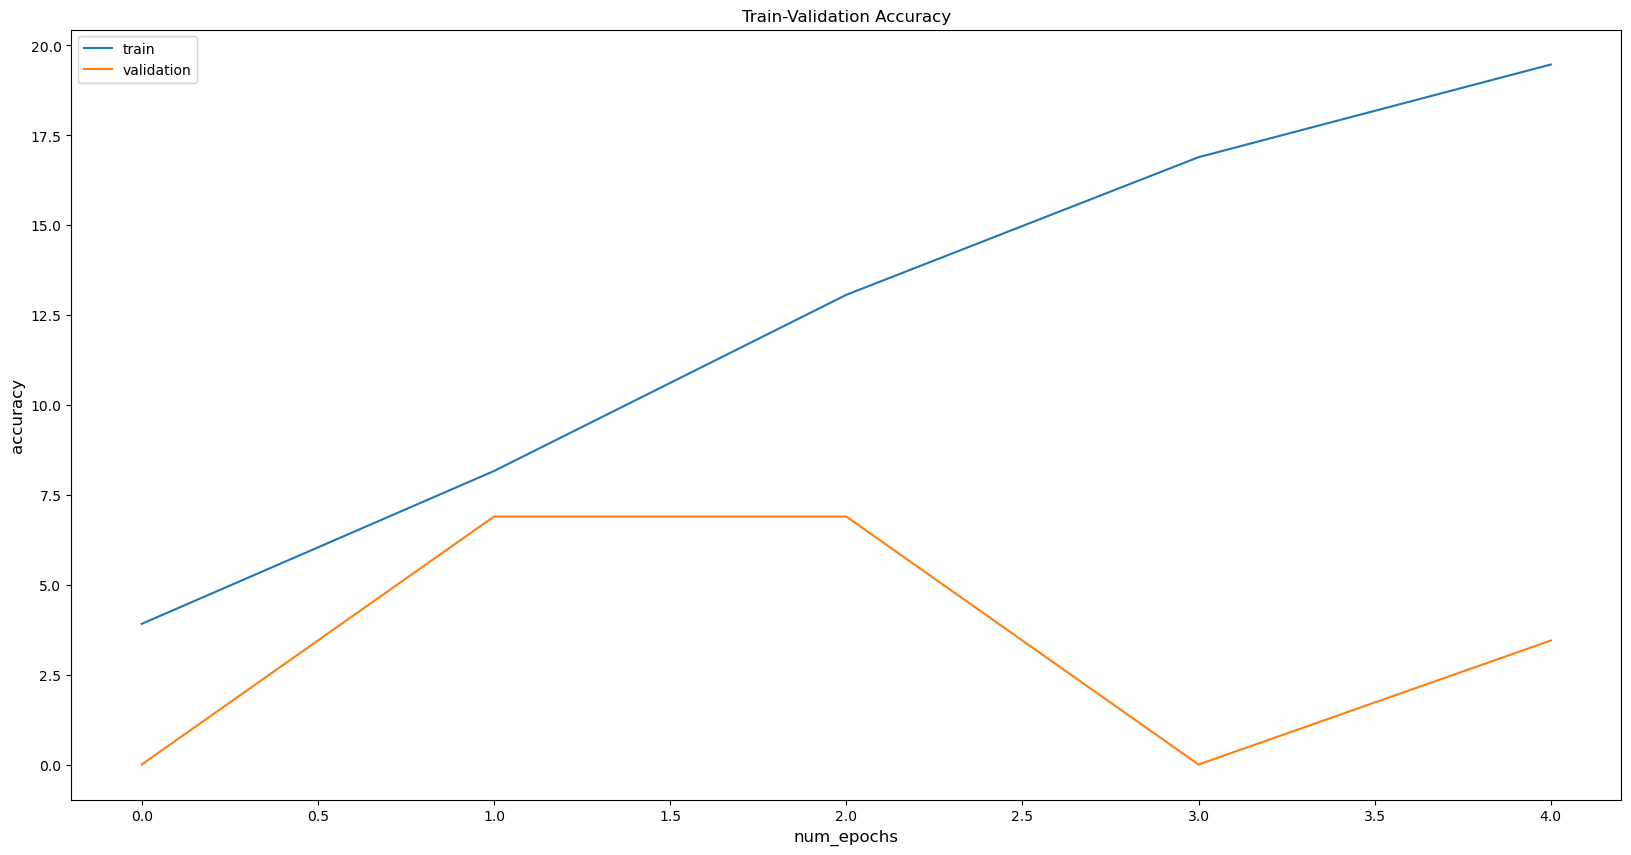

In [11]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')